In [1]:
import numpy as np # linear algebra

In [2]:
# %cd "Upernet"
%cd "SegFormer"

/home/work2/Workspace/sonnh/do_an_test/SegFormer


In [3]:
import os
import random
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
# from models import upernet_convnext_tiny_org
from models import SegFormer_B0

2024-07-02 23:15:02.644445: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 23:15:02.663391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 23:15:02.663411: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 23:15:02.663421: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 23:15:02.667205: I tensorflow/core/platform/cpu_feature_g

In [4]:
save_train_image_dataset_path = '../bk-isut-dataset/train_image_dataset.npy'
save_val_image_dataset_path = '../bk-isut-dataset/val_image_dataset.npy'
save_test_image_dataset_path = '../bk-isut-dataset/test_image_dataset.npy'
save_train_mask_image_dataset_path = '../bk-isut-dataset/mask_train_image_dataset.npy'
save_val_mask_image_dataset_path = '../bk-isut-dataset/mask_val_image_dataset.npy'
save_test_mask_image_dataset_path = '../bk-isut-dataset/mask_test_image_dataset.npy'

In [5]:
X_train = np.load(save_train_image_dataset_path, mmap_mode='c')
X_val = np.load(save_val_image_dataset_path, mmap_mode='c')
X_test = np.load(save_test_image_dataset_path, mmap_mode='c')
y_train = np.load(save_train_mask_image_dataset_path, mmap_mode='c')
y_val = np.load(save_val_mask_image_dataset_path, mmap_mode='c')
y_test = np.load(save_test_mask_image_dataset_path, mmap_mode='c')

In [6]:
os.environ["SM_FRAMEWORK"] = "tf.keras" 
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [7]:
checkpoint_path1 = "../weights/augmented_segformer_B0/cp.weights.h5"
checkpoint_path2 = "../weights/offline_distill/cp.segformer_student_pretrain_converge.h5"

In [8]:
model_name1 = 'SegformerB0 (Vanilla)'
model_name2 = 'SegformerB0 (Fine tuned + Distill)'
file_name = 'patch_prediction_fine_tuned_segformer_B0'

In [9]:
model1 = SegFormer_B0(input_shape = (256,256,3), num_classes = 5)
model2 = SegFormer_B0(input_shape = (256,256,3), num_classes = 5)
# model = upernet_convnext_tiny_org.UPerNet(input_shape = (256,256,3), num_classes = 5)
# model = sm.FPN('resnet50', classes=5, activation='softmax')


2024-07-02 23:15:03.686296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 23:15:03.689163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 23:15:03.689247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
model1.load_weights(checkpoint_path1)
model2.load_weights(checkpoint_path2)

1/1 [==============================] - 0s 15ms/step


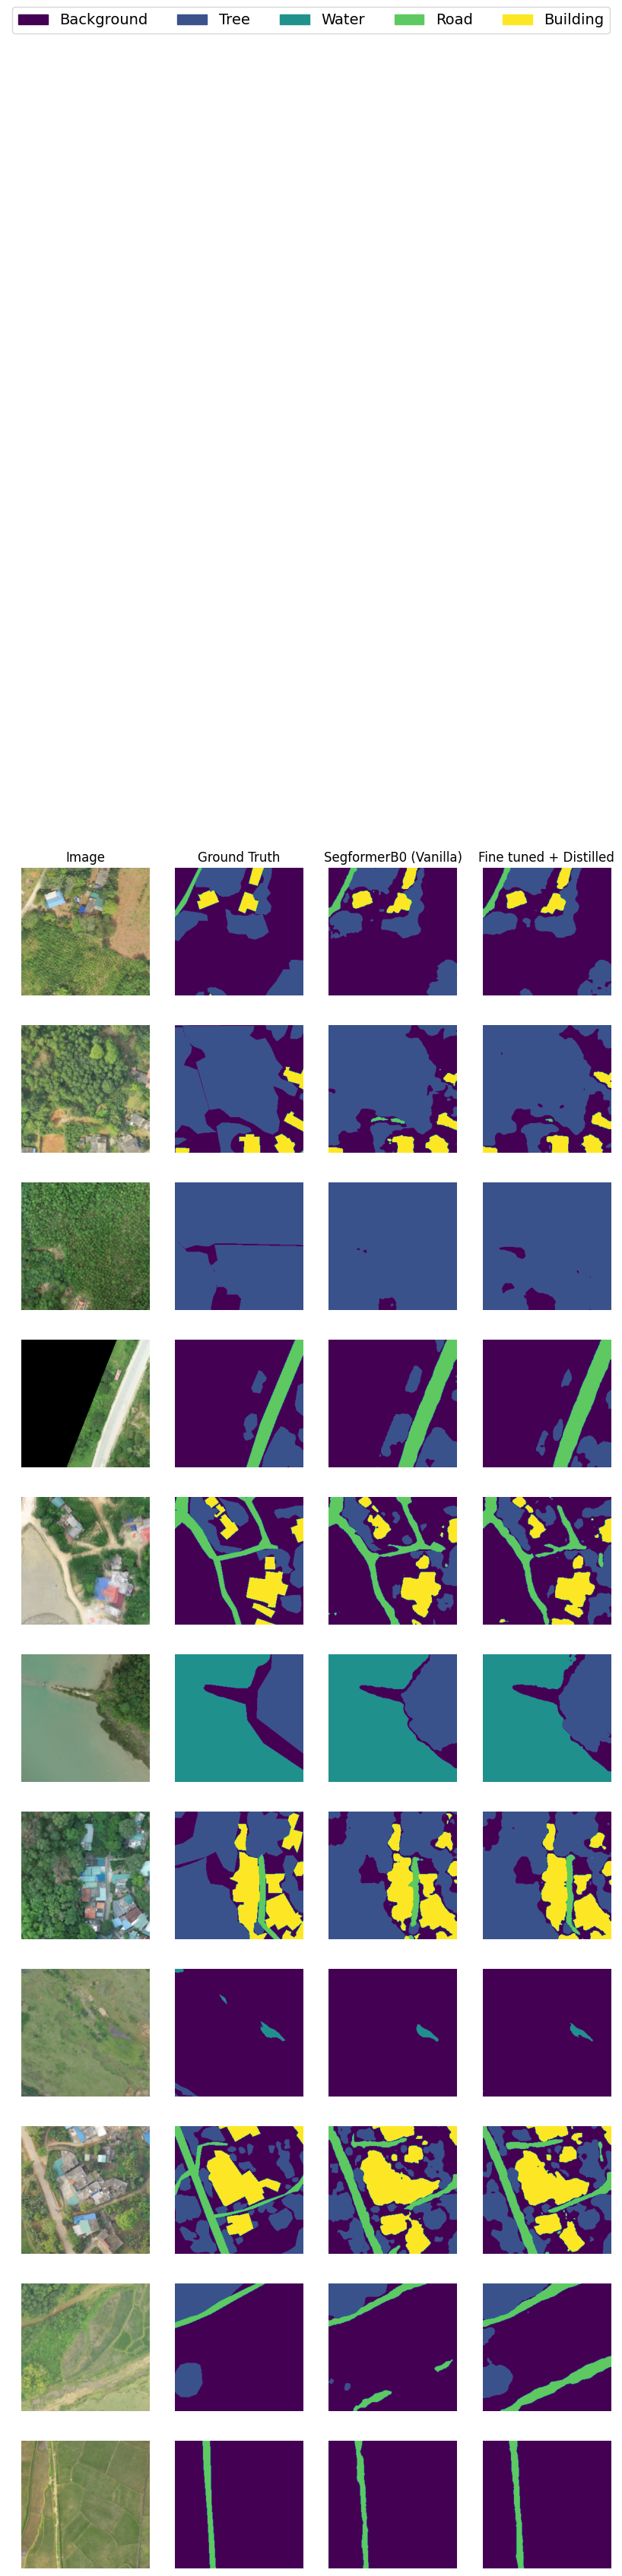

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

vmin = 0
vmax = 4

# Use a default Matplotlib colormap (tab10)
cmap = plt.get_cmap(lut=5)

# Define the boundaries for the colormap
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)



# Placeholder lists to store images and titles
images = []
titles = []

for i in range(11):
    # image_number = i
    image_number = random.randint(0, X_test.shape[0] - 1)
    
    # Original Image
    images.append(X_test[image_number])
    titles.append('Image')

    # Ground Truth
    true = y_test[image_number].argmax(axis=2)
    images.append(true)
    titles.append('Ground Truth')

    # Prediction1
    prediction1 = model1.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)
    images.append(prediction1)
    titles.append(model_name1)

    # Prediction2
    prediction2 = model2.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)
    images.append(prediction2)
    titles.append('Fine tuned + Distilled')

# Plot all images in a single figure
fig, axes = plt.subplots(11, 4, figsize=(10, 38))
fig.subplots_adjust(top=0.7)

# Create custom legend patches using colors from the 'tab10' colormap
legend_labels = ['Background', 'Tree', 'Water', 'Road', 'Building']
colors = [cmap(i) for i in range(len(legend_labels))]
legend_handles = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(colors))]

# Add a custom legend for the classes
# handles = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], vmin=vmin, vmax=vmax)
    if i < 4:
        ax.set_title(titles[i % 4])
    ax.axis('off')

# Save the figure to the specified folder and file name
# folder = '../infer_image'
# filename = file_name
# filepath = os.path.join(folder, filename)

# # Ensure the directory exists
# os.makedirs(folder, exist_ok=True)
# fig.savefig(filepath )

plt.show()


